In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import os
import time
from datetime import timedelta
from matplotlib.ticker import MultipleLocator



import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor

from sklearn import model_selection, preprocessing, metrics, tree
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import IsolationForest, BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.metrics import make_scorer ,confusion_matrix, mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, ElasticNet, HuberRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection



%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

seed_val = 42

In [ ]:
# constants
DATA_PATH = '/kaggle/dev/mercedes-benz-greener-manufacturing-data/raw_data/'
SUBMISSION_PATH = '/kaggle/dev/mercedes-benz-greener-manufacturing-data/submissions'
ENSEMBLE_PATH = '/kaggle/dev/mercedes-benz-greener-manufacturing-data/ensemble/jsardinha/'
ASSET_PATH = '/kaggle/dev/jovan/mercedes-benz-greener-manufacturing/mercedes-benz-greener-manufacturing/assets/'

In [42]:
# loading the data
train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
sample_submission = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))

# reseting index
#train = train.set_index('ID')
#test = test.set_index('ID')

## Pre processing

In [43]:
# X0 groups
train['eng1_X0_group'] = train[['X0']].apply(lambda x: 0 if x['X0'] in ['bc', 'az']
                                       else 0 if x['X0']  in ['ac', 'am', 'l', 'b', 'aq', 'u', 'ad', 'e', 
                                                                 'al', 's', 'n', 'y', 't', 'ai', 'k', 'f', 'z', 
                                                                 'o', 'ba', 'm', 'q']
                                       else 2 if x['X0'] in ['d', 'ay', 'h', 'aj', 'v', 'ao', 'aw']
                                       else 3 if x['X0'] in ['c', 'ax', 'x', 'j', 'w', 'i',
                                                                'ak', 'g', 'at', 'ab', 'af', 'r', 'as', 'a', 'ap',
                                                                'au', 'aa']
                                       else 4, axis=1)

test['eng1_X0_group'] = test[['X0']].apply(lambda x: 0 if x['X0'] in ['bc', 'az']
                                       else 1 if x['X0']  in ['ac', 'am', 'l', 'b', 'aq', 'u', 'ad', 'e', 
                                                                 'al', 's', 'n', 'y', 't', 'ai', 'k', 'f', 'z', 
                                                                 'o', 'ba', 'm', 'q']
                                       else 2 if x['X0'] in ['d', 'ay', 'h', 'aj']
                                       else 3 if x['X0'] in ['v', 'ao', 'aw', 'c', 'ax', 'x', 'j', 'w', 'i',
                                                                'ak', 'g', 'at', 'ab', 'af', 'r', 'as', 'a', 'ap',
                                                                'au', 'aa']
                                       else 4, axis=1)



#X5 groups
train['eng1_X5_groups'] = train[['X5']].apply(lambda x: 0 if x['X5'] in ['h', 'x']
                                         else 1 if x['X5'] in ['y', 'g', 'o'] 
                                         else 2 if x['X5'] in ['aa', 'r', 'ah', 'w', 'k', 'ac', 'v', 'q', 'l',
                                                                  'j', 'p', 'i', 'd', 'ae', 'ag', 's', 'n', 'm',
                                                                  'af', 'ab', 'ad', 'c', 'f']
                                         else 3 if x['X5'] in ['u']
                                         else 4, axis=1)

test['eng1_X5_groups'] = test[['X5']].apply(lambda x: 0 if x['X5'] in ['h', 'x']
                                         else 1 if x['X5'] in ['y', 'g', 'o'] 
                                         else 2 if x['X5'] in ['aa', 'r', 'ah', 'w', 'k', 'ac', 'v', 'q', 'l',
                                                                  'j', 'p', 'i', 'd', 'ae', 'ag', 's', 'n', 'm',
                                                                  'af', 'ab', 'ad', 'c', 'f']
                                         else 3 if x['X5'] in ['u']
                                         else 4, axis=1)

In [44]:
#X0_group version 2
train['eng1_X0_group_2'] = train[['X127', 'X118', 'X238']].apply(lambda x: 0 if(x['X127']==0 and x['X118']==0 and x['X238']==0)
                                                             else 1 if(x['X127']==1)
                                                             else 2 if(x['X127']==0 and x['X118']==0 and x['X238']==1)
                                                             else 3 if(x['X127']==0 and x['X118']==1)
                                                             else 4, axis=1)

test['eng1_X0_group_2'] = test[['X127', 'X118', 'X238']].apply(lambda x: 0 if(x['X127']==0 and x['X118']==0 and x['X238']==0)
                                                             else 1 if(x['X127']==1)
                                                             else 2 if(x['X127']==0 and x['X118']==0 and x['X238']==1)
                                                             else 3 if(x['X127']==0 and x['X118']==1)
                                                             else 4, axis=1)

In [45]:
train['eng1_bin_sum'] = train.iloc[:,10:378].apply(lambda x: np.sum(x), axis=1 )
test['eng1_bin_sum'] = test.iloc[:,9:377].apply(lambda x: np.sum(x), axis=1 )

### Data Cleaning

In [46]:
cols_drop = []
cols_drop.append(['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X347']) # zero-var cols
#cols_drop.append(['X5'])
for i, col in enumerate(cols_drop):
    train = train.drop(col, 1)
    test = test.drop(col, 1)

### Dopping outliers

In [47]:
outlier_col = 'is_outlier_2-5'
train_outliers_file = 'train_outlier_list.csv'
train_outliers = pd.read_csv(os.path.join(ASSET_PATH, train_outliers_file))
train_outliers = train_outliers[['ID', outlier_col]]

# test_outliers_file = 'test_outlier_list.csv'
# test_outliers = pd.read_csv(os.path.join(ASSET_PATH, test_outliers_file))
# test_outliers = test_outliers[['ID', outlier_col]]

train = pd.merge(train, train_outliers, how='inner', on='ID')
# test = pd.merge(test, test_outliers, how='inner', on='ID')

In [48]:
post_analysis = train.copy()

In [49]:
train = train[train[outlier_col]==0]
train = train.drop(outlier_col, 1)

In [64]:
outlier_threshold = 5
outlier_multiplier = 10
train_outliers_file = 'train_outlier_list.csv'
train_outliers = pd.read_csv(os.path.join(ASSET_PATH, train_outliers_file))
train_outliers['outlier_score'] = train_outliers.apply(lambda x: 
                                                       (np.sum(x[1:]) - outlier_threshold)*outlier_multiplier
                                                       , axis=1)
train_outliers['outlier_score'] = train_outliers.apply(lambda x: 0 if x['outlier_score']<0 
                                                       else x['outlier_score']
                                                       , axis=1)

#train_outliers = train_outliers[['ID', 'outlier_score']]


test_outliers_file = 'test_outlier_list.csv'
test_outliers = pd.read_csv(os.path.join(ASSET_PATH, test_outliers_file))
test_outliers['outlier_score'] = test_outliers.apply(lambda x: 
                                                       (np.sum(x[1:]) - outlier_threshold)*outlier_multiplier
                                                       , axis=1)
test_outliers['outlier_score'] = test_outliers.apply(lambda x: 0 if x['outlier_score']<0 
                                                       else x['outlier_score']
                                                       , axis=1)
#test_outliers = test_outliers[['ID', 'outlier_score']]

In [70]:
train_outliers[train_outliers['is_outlier_4-0']==1].shape

(2, 12)

### Traning

In [51]:
target_col = ['y']
ignore_cols = []
ignore_cols.append(target_col[0])
train_cols = [col for col in train.columns if col not in ignore_cols]

train_x = train[train_cols]
train_y = train[target_col]
test_x = test[train_cols]

print('--- encoding columns from train and test datasets ---')
for f in train_x.columns:
    if train_x[f].dtype=='object':
        print('encoding column:', f, '(original dtype:', train_x[f].dtype, ')')
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(set(train_x[f].values)| set(test_x[f].values))) 
        train_x[f] = lbl.transform(list(train_x[f].values))
        test_x[f] = lbl.transform(list(test_x[f].values))

--- encoding columns from train and test datasets ---
encoding column: X0 (original dtype: object )
encoding column: X1 (original dtype: object )
encoding column: X2 (original dtype: object )
encoding column: X3 (original dtype: object )
encoding column: X4 (original dtype: object )
encoding column: X5 (original dtype: object )
encoding column: X6 (original dtype: object )
encoding column: X8 (original dtype: object )


In [52]:
def xgb_r2(y_pred, dtrain):
    y_true = dtrain.get_label()
    r2_sklearn = r2_score(y_true, y_pred)
    r2_sklearn = r2_sklearn * -1.0
    return 'error', r2_sklearn

In [53]:
def oof_regression_predictor(train_x, train_y, test_x, n_folds, estimators, pred_cols, 
                             train_eval_metric, compare_eval_metric):
    
    start_time = time.time()
                                              
    # initializing blending data frames
    train_blend = train_x
    test_blend = test_x

    # Note: StratifiedKFold splits into roughly 66% train 33% test  
    skf = list(StratifiedKFold(train_y.values.ravel(), n_folds, random_state=seed_val))
    
    dataset_blend_train = np.zeros((train_x.shape[0], len(estimators)))
    dataset_blend_test = np.zeros((test_x.shape[0], len(estimators)))
    
    for j, estimator in enumerate(estimators):
        dataset_blend_test_j = np.zeros((test_x.shape[0], len(skf)))
        for i, (train, test) in enumerate(skf):
            trn_x = train_x.iloc[train, :] 
            trn_y = train_y.iloc[train].values.ravel()
            val_x = train_x.iloc[test, :] 
            val_y = train_y.iloc[test].values.ravel()

            # if xgb
            if ( 'dict' in str(type(estimator))):
                eval_set = [(trn_x, trn_y),(val_x, val_y)]
                model = XGBRegressor(**estimator).fit(trn_x, trn_y, eval_set=eval_set, verbose=False, 
                                                eval_metric=train_eval_metric)
            
            # else sklean
            else:          
                model = estimator.fit(trn_x, trn_y)
                
            pred_train = model.predict(val_x)
            dataset_blend_train[test, j] = pred_train
            print('fold:', i+1, '/', n_folds, '; estimator:',  j+1, '/', len(estimators), ' -> oof cv score:', 
                  compare_eval_metric(val_y, pred_train) , "  ")

            pred_test = model.predict(test_x)
            dataset_blend_test_j[:, i] = pred_test
    
        dataset_blend_test[:, j] = np.mean(dataset_blend_test_j, axis=1)
        
        
    print('--- comparing models ---  ')
    # comparing models
    for i in range(dataset_blend_train.shape[1]):
        print('model', i+1, 'cv score:', compare_eval_metric(train_y, dataset_blend_train[:,i]), "  ")
        
    for i, j in enumerate(estimators):
        train_blend[pred_cols[i]] = dataset_blend_train[:,i]
        test_blend[pred_cols[i]] = dataset_blend_test[:,i]
    
    end_time = time.time()
    print("Total Time usage: " + str(timedelta(seconds=int(round(end_time - start_time)))))
    return train_blend, test_blend, model

In [54]:
# Predictors
estimators = [{
        'objective': "reg:linear",
        'max_depth': 5,
        'n_estimators': 100,
        'learning_rate': 0.05,
        'nthread': 12,
        'seed': seed_val,
        'subsample': 0.7,
         'colsample_bytree': 0.7,
        'min_child_weight': 1,
        'gamma':10,
        'silent': True
    }]

pred_cols = ['pred1_xgb_y_pred']

train_blend, test_blend, model = oof_regression_predictor(train_x, 
                                                     train_y, 
                                                     test_x, 
                                                     n_folds = 5, 
                                                     estimators=estimators, 
                                                     pred_cols = pred_cols,  
                                                     train_eval_metric=xgb_r2,
                                                     compare_eval_metric=r2_score)

/kaggle/dev/jovan/mercedes-benz-greener-manufacturing/venv-mercedes/lib/python3.5/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


fold: 1 / 5 ; estimator: 1 / 1  -> oof cv score: 0.559105878875   
fold: 2 / 5 ; estimator: 1 / 1  -> oof cv score: 0.643193152724   
fold: 3 / 5 ; estimator: 1 / 1  -> oof cv score: 0.710979973586   
fold: 4 / 5 ; estimator: 1 / 1  -> oof cv score: 0.805184005297   
fold: 5 / 5 ; estimator: 1 / 1  -> oof cv score: 0.450464766047   
--- comparing models ---  
model 1 cv score: 0.59413450567   
Total Time usage: 0:00:02


In [55]:
print('--- encoding columns from train and test datasets ---')
for f in post_analysis.columns:
    if post_analysis[f].dtype=='object':
        print('encoding column:', f, '(original dtype:', post_analysis[f].dtype, ')')
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(set(post_analysis[f].values))) 
        post_analysis[f] = lbl.transform(list(post_analysis[f].values))

--- encoding columns from train and test datasets ---
encoding column: X0 (original dtype: object )
encoding column: X1 (original dtype: object )
encoding column: X2 (original dtype: object )
encoding column: X3 (original dtype: object )
encoding column: X4 (original dtype: object )
encoding column: X5 (original dtype: object )
encoding column: X6 (original dtype: object )
encoding column: X8 (original dtype: object )


In [56]:
#post_analysis = train_x.copy()
post_analysis['y_pred'] = model.predict(post_analysis[train_cols])
post_analysis['y_true'] = post_analysis['y']
post_analysis['residuals'] = post_analysis[['y_pred', 'y_true']].apply(lambda x: x['y_true'] - x['y_pred'], axis=1)

In [57]:
post_analysis = pd.merge(post_analysis, train_outliers, on='ID', how='left')
post_analysis['y_pred'] = post_analysis.apply(lambda x: x['y_pred'] + x['outlier_score'], axis=1)
post_analysis.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X94,X95,X96,X97,X98,X99,X100,X101,X102,X103,X104,X105,X106,X108,X109,X110,X111,X112,X113,X114,X115,X116,X117,X118,X119,X120,X122,X123,X124,X125,X126,X127,X128,X129,X130,X131,X132,X133,X134,X135,X136,X137,X138,X139,X140,X141,X142,X143,X144,X145,X146,X147,X148,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,X179,X180,X181,X182,X183,X184,X185,X186,X187,X189,X190,X191,X192,X194,X195,X196,X197,X198,X199,X200,X201,X202,X203,X204,X205,X206,X207,X208,X209,X210,X211,X212,X213,X214,X215,X216,X217,X218,X219,X220,X221,X222,X223,X224,X225,X226,X227,X228,X229,X230,X231,X232,X234,X236,X237,X238,X239,X240,X241,X242,X243,X244,X245,X246,X247,X248,X249,X250,X251,X252,X253,X254,X255,X256,X257,X258,X259,X260,X261,X262,X263,X264,X265,X266,X267,X269,X270,X271,X272,X273,X274,X275,X276,X277,X278,X279,X280,X281,X282,X283,X284,X285,X286,X287,X288,X291,X292,X294,X295,X296,X298,X299,X300,X301,X302,X304,X305,X306,X307,X308,X309,X310,X311,X312,X313,X314,X315,X316,X317,X318,X319,X320,X321,X322,X323,X324,X325,X326,X327,X328,X329,X331,X332,X333,X334,X335,X336,X337,X338,X339,X340,X341,X342,X343,X344,X345,X346,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385,eng1_X0_group,eng1_X5_groups,eng1_X0_group_2,eng1_bin_sum,is_outlier_2-5,y_pred,y_true,residuals,outlier_score
0,0,130.81,32,23,17,0,3,24,9,14,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3,3,52,0,114.574677,130.81,16.235323,0
1,6,88.53,32,21,19,4,3,28,11,14,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,52,0,92.390541,88.53,-3.860541,0
2,7,76.26,20,24,34,2,3,27,9,23,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,1,0,1,1,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,

In [58]:
r2_score(post_analysis['y_true'],post_analysis['y_pred'])

0.67995666743323968

In [59]:
post_analysis['residuals'] = post_analysis[['y_pred', 'y_true']].apply(lambda x: x['y_true'] - x['y_pred'], axis=1)

In [60]:
# fig, ax1 = plt.subplots(figsize=(20,12))
# ax2 = ax1.twinx()
# plt.title('Post Analysis')
# ax1.set_ylabel('y')
# ax2.set_ylabel('residuals [y_true - y_pred]')
# plt.xlabel('user_id')
# ax1.plot(post_analysis.index.values, post_analysis['y_true'],'ro', alpha=0.30)
# ax1.plot(post_analysis.index.values, post_analysis['y_pred'],'go', alpha=0.30)
# ax2.plot(post_analysis.index.values, post_analysis['residuals'],'bv', alpha=0.50)
# ax1.yaxis.set_major_locator(MultipleLocator(10))
# ax2.yaxis.set_major_locator(MultipleLocator(10))
# plt.show()

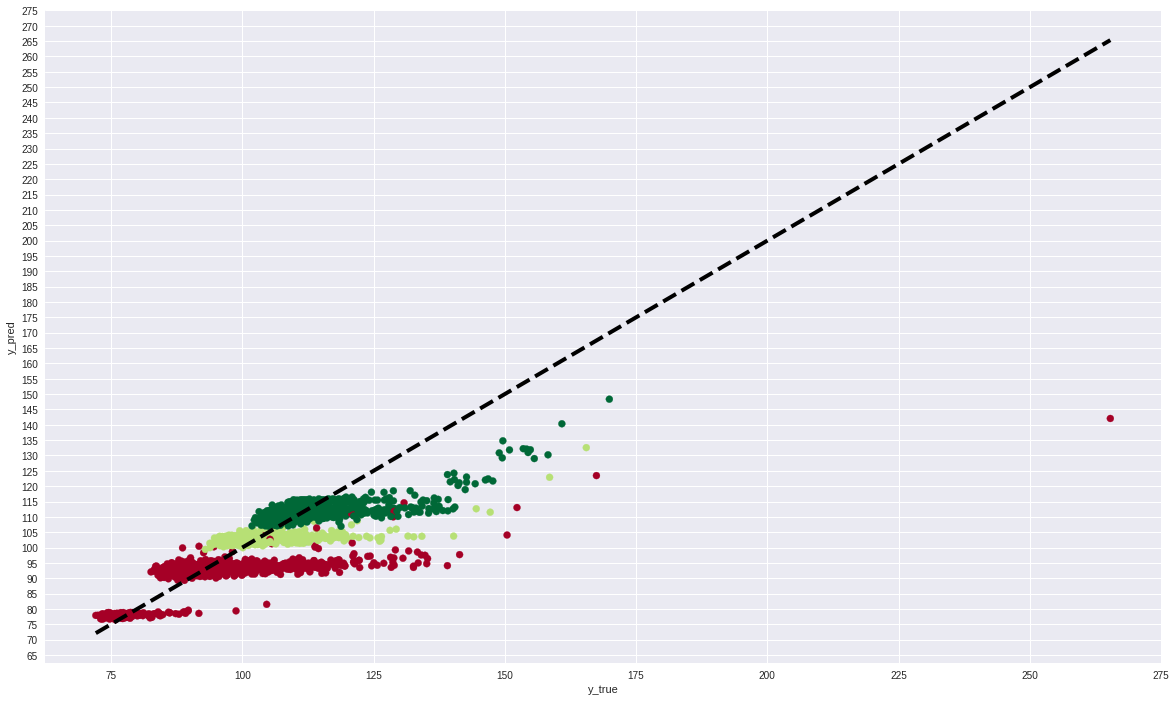

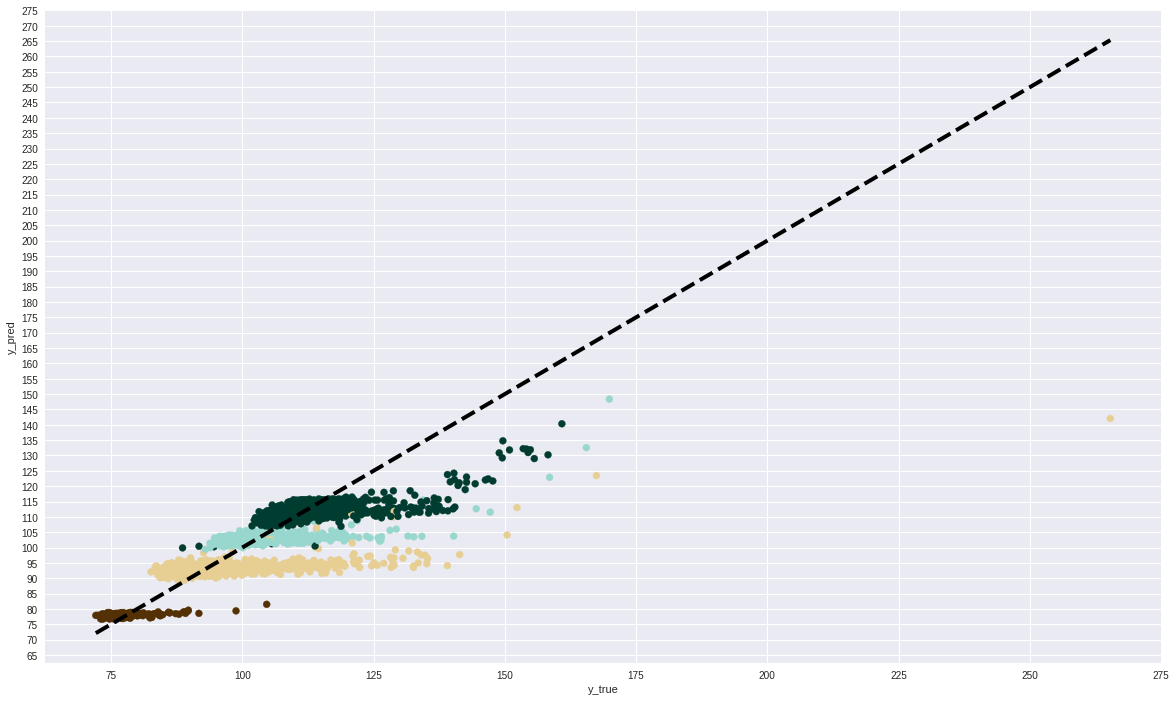

In [61]:
majorLocator = MultipleLocator(5)
fig, ax = plt.subplots(figsize=(20,12))
plt.scatter( post_analysis['y_true'],  post_analysis['y_pred'], c=post_analysis['eng1_X0_group'], cmap=plt.cm.RdYlGn)
plt.plot([ post_analysis['y_true'].min(),  post_analysis['y_true'].max()], 
        [ post_analysis['y_true'].min(),  post_analysis['y_true'].max()], 'k--', lw=4)
ax.yaxis.set_major_locator(majorLocator)
ax.set_xlabel('y_true')
ax.set_ylabel('y_pred')
plt.show()


majorLocator = MultipleLocator(5)
fig, ax = plt.subplots(figsize=(20,12))
plt.scatter( post_analysis['y_true'],  post_analysis['y_pred'], c=post_analysis['eng1_X0_group_2'], cmap=plt.cm.BrBG)
plt.plot([ post_analysis['y_true'].min(),  post_analysis['y_true'].max()], 
        [ post_analysis['y_true'].min(),  post_analysis['y_true'].max()], 'k--', lw=4)
ax.yaxis.set_major_locator(majorLocator)
ax.set_xlabel('y_true')
ax.set_ylabel('y_pred')
plt.show()

In [62]:
# fig, ax = plt.subplots(figsize=(12,100))
# xgb.plot_importance(model, height=0.8, ax=ax, title='Feature importance of blended model')

##### dupes

In [63]:
train_df_id_idx = train.set_index(['ID'], drop=True)
tot_cols = train_df_id_idx.columns
tot_cols = set(tot_cols) #-  set(['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8'])
train_df_id_idx = train_df_id_idx[list(tot_cols)]
df = train_df_id_idx.drop(['y'], axis=1).duplicated(keep=False)
dupes_X = train_df_id_idx.drop(['y'], axis=1)[df]

In [25]:
# train_df_id_idx = train.set_index(['ID'], drop=True)
# df = train_df_id_idx.drop(['y'], axis=1).duplicated(keep=False)
# dupes_X = train_df_id_idx.drop(['y'], axis=1)[df]
# dupe_ids = dupes_X.index.values
# dupes = train_df_id_idx[train_df_id_idx.index.isin(dupe_ids)]
# train_columns = list(set(dupes.columns) - set(['ID', 'y']))
# mean_y = dupes.groupby(train_columns).y.mean().reset_index().rename(columns={'y':'mean_y'})
# median_y = dupes.groupby(train_columns).y.median().reset_index().rename(columns={'y':'mean_y'})
# variance_y = dupes.groupby(train_columns).y.var().reset_index().rename(columns={'y':'variance_y'})
# std_y = dupes.groupby(train_columns).y.std().reset_index().rename(columns={'y':'std_y'})
# temp = pd.merge(dupes, mean_y, on=train_columns, how='left')
# temp = pd.merge(temp, median_y, on=train_columns, how='left')
# temp = pd.merge(temp, variance_y, on=train_columns, how='left')
# temp = pd.merge(temp, std_y, on=train_columns, how='left')
# result = temp.sort_index().sort_values(train_columns)
# result['residual_y'] = result.y - result.mean_y_x

dupes_X = dupes_X.reset_index()
#result = result.rename(columns={'index':'ID'})
dupes_X['is_dupe'] = 1
dupes_X = dupes_X[['ID', 'is_dupe']]

In [26]:
print(dupes_X.shape)
print(train.shape)
print(100*(dupes_X.shape[0]/train.shape[0]))

(508, 2)
(4175, 370)
12.167664670658683


In [27]:
post_analysis = pd.merge(post_analysis, dupes_X, on='ID', how='left')
post_analysis['is_dupe'] = post_analysis['is_dupe'].apply(lambda x: 1 if x==1.0 else 0)

##### outliers

In [28]:
# outliers_isof = pd.read_csv(os.path.join(ASSET_PATH, 'train-isof-outliers_default.csv'))
# outliers_isof['is_isof_outlier'] = 1.0
# outliers_isof = outliers_isof[['ID', 'is_isof_outlier']]

In [29]:
# post_analysis = pd.merge(post_analysis, outliers_isof, on='ID', how='left')
# post_analysis['is_isof_outlier'] = post_analysis['is_isof_outlier'].apply(lambda x: 1 if x==1.0 else 0)

In [30]:
def outlier_detector(outlier_name, outlier_file):
    global post_analysis
    outliers = pd.read_csv(os.path.join(ASSET_PATH, outlier_file))
    outliers = outliers[['ID', outlier_name]]
    post_analysis = pd.merge(post_analysis, outliers, on='ID', how='left')
    post_analysis[outlier_name] = post_analysis[outlier_name].apply(lambda x: 1 if x==1.0 else 0)
    return
    
# outlier_detector('is_outlier_3_5', 'train-outliers_3-5.csv')
# outlier_detector('is_outlier_3_0', 'train-outliers_3-0.csv')
# outlier_detector('is_outlier_2_5', 'train-outliers_2-5.csv')
# outlier_detector('is_outlier_2_0', 'train-outliers_2-0.csv')
# outlier_detector('is_outlier_1_5', 'train-outliers_1-5.csv')
# outlier_detector('is_outlier_1_0', 'train-outliers_1-0.csv')

#outlier_detector('is_outlier_2-5', 'train_outlier_list.csv')

In [31]:
post_analysis.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X94,X95,X96,X97,X98,X99,X100,X101,X102,X103,X104,X105,X106,X108,X109,X110,X111,X112,X113,X114,X115,X116,X117,X118,X119,X120,X122,X123,X124,X125,X126,X127,X128,X129,X130,X131,X132,X133,X134,X135,X136,X137,X138,X139,X140,X141,X142,X143,X144,X145,X146,X147,X148,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,X179,X180,X181,X182,X183,X184,X185,X186,X187,X189,X190,X191,X192,X194,X195,X196,X197,X198,X199,X200,X201,X202,X203,X204,X205,X206,X207,X208,X209,X210,X211,X212,X213,X214,X215,X216,X217,X218,X219,X220,X221,X222,X223,X224,X225,X226,X227,X228,X229,X230,X231,X232,X234,X236,X237,X238,X239,X240,X241,X242,X243,X244,X245,X246,X247,X248,X249,X250,X251,X252,X253,X254,X255,X256,X257,X258,X259,X260,X261,X262,X263,X264,X265,X266,X267,X269,X270,X271,X272,X273,X274,X275,X276,X277,X278,X279,X280,X281,X282,X283,X284,X285,X286,X287,X288,X291,X292,X294,X295,X296,X298,X299,X300,X301,X302,X304,X305,X306,X307,X308,X309,X310,X311,X312,X313,X314,X315,X316,X317,X318,X319,X320,X321,X322,X323,X324,X325,X326,X327,X328,X329,X331,X332,X333,X334,X335,X336,X337,X338,X339,X340,X341,X342,X343,X344,X345,X346,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385,eng1_X0_group,eng1_X5_groups,eng1_X0_group_2,eng1_bin_sum,is_outlier_2-5,y_pred,y_true,residuals,outlier_score,is_dupe
0,0,130.81,32,23,17,0,3,24,9,14,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3,3,52,0,114.574677,130.81,16.235323,0,0
1,6,88.53,32,21,19,4,3,28,11,14,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,52,0,92.390541,88.53,-3.860541,0,0
2,7,76.26,20,24,34,2,3,27,9,23,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,1,0,1,1,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,

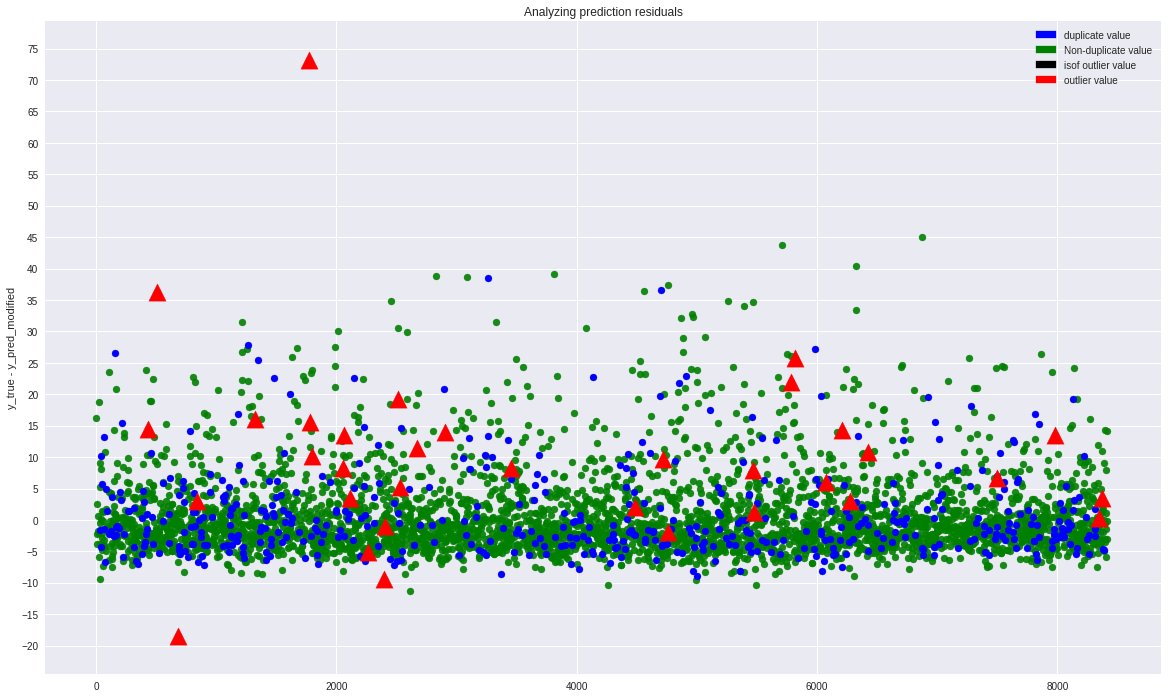

In [32]:
majorLocator = MultipleLocator(5)
fig, ax = plt.subplots(figsize=(20,12))
# plt.scatter(post_analysis[post_analysis['is_isof_outlier']==1.0].ID, post_analysis[post_analysis['is_isof_outlier']==1.0]
#             .residuals, color='Black', s=300, marker='x')


plt.scatter(post_analysis[post_analysis['is_dupe']==0.0].ID, post_analysis[post_analysis['is_dupe']==0.0].
            residuals, color="Green", alpha=0.90)
plt.scatter(post_analysis[post_analysis['is_dupe']==1.0].ID, post_analysis[post_analysis['is_dupe']==1.0].
            residuals, color="Blue")

# plt.scatter(post_analysis[post_analysis['is_outlier_3_5']==1.0].ID, post_analysis[post_analysis['is_outlier_3_5']==1.0]
#             .residuals, color='Red', s=300, marker='^')
# plt.scatter(post_analysis[post_analysis['is_outlier_3_0']==1.0].ID, post_analysis[post_analysis['is_outlier_3_0']==1.0]
#             .residuals, color='Red', s=300, marker='^')
plt.scatter(post_analysis[post_analysis['is_outlier_2-5']==1].ID, post_analysis[post_analysis['is_outlier_2-5']==1]
            .residuals, color='Red', s=300, marker='^')
# plt.scatter(post_analysis[post_analysis['is_outlier_2_0']==1.0].ID, post_analysis[post_analysis['is_outlier_2_0']==1.0]
#             .residuals, color='Red', s=300, marker='^')
# plt.scatter(post_analysis[post_analysis['is_outlier_1_5']==1.0].ID, post_analysis[post_analysis['is_outlier_1_5']==1.0]
#             .residuals, color='Red', s=300, marker='^')
# plt.scatter(post_analysis[post_analysis['is_outlier_1_0']==1.0].ID, post_analysis[post_analysis['is_outlier_1_0']==1.0]
#             .residuals, color='Red', s=300, marker='^')


ax.yaxis.set_major_locator(majorLocator)
plt.title('Analyzing prediction residuals')
ax.set_ylabel('y_true - y_pred_modified')

blue_patch = mpatches.Patch(color='blue', label='duplicate value')
green_patch = mpatches.Patch(color='green', label='Non-duplicate value')
black_patch = mpatches.Patch(color='black', label='isof outlier value')
red_patch = mpatches.Patch(color='red', label='outlier value')
plt.legend(handles=[blue_patch, green_patch, black_patch, red_patch])
plt.show()

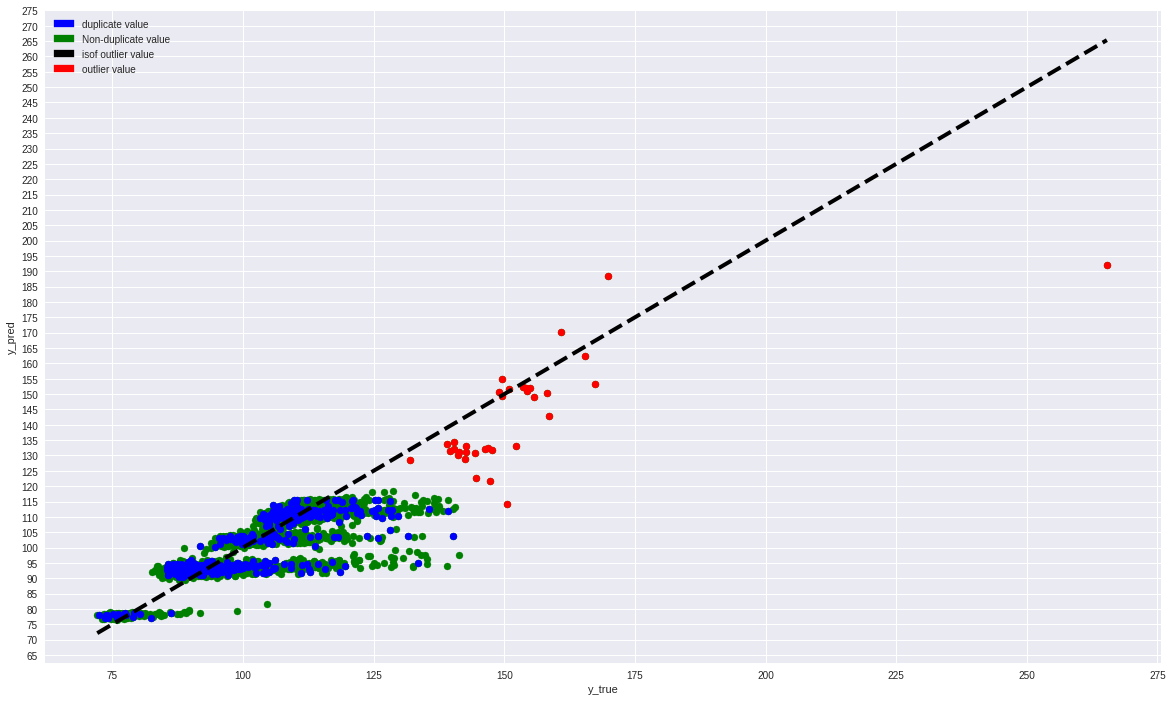

In [33]:
majorLocator = MultipleLocator(5)
fig, ax = plt.subplots(figsize=(20,12))
plt.scatter(post_analysis['y_true'],  post_analysis['y_pred'], color='Green')
plt.scatter(post_analysis[post_analysis['is_dupe']==1.0].y_true,  post_analysis[post_analysis['is_dupe']==1.0].y_pred,
           color='Blue')
plt.scatter(post_analysis[post_analysis['is_outlier_2-5']==1.0].y_true,  post_analysis[post_analysis['is_outlier_2-5']==1.0].y_pred,
           color='Red')
# plt.scatter(post_analysis[post_analysis['is_isof_outlier']==1.0].y_true,  post_analysis[post_analysis['is_isof_outlier']==1.0].y_pred,
#            color='Black')
plt.plot([ post_analysis['y_true'].min(),  post_analysis['y_true'].max()], 
        [ post_analysis['y_true'].min(),  post_analysis['y_true'].max()], 'k--', lw=4)
ax.yaxis.set_major_locator(majorLocator)
ax.set_xlabel('y_true')
ax.set_ylabel('y_pred')

blue_patch = mpatches.Patch(color='blue', label='duplicate value')
green_patch = mpatches.Patch(color='green', label='Non-duplicate value')
black_patch = mpatches.Patch(color='black', label='isof outlier value')
red_patch = mpatches.Patch(color='red', label='outlier value')
plt.legend(handles=[blue_patch, green_patch, black_patch, red_patch])

plt.show()

### Submission

In [34]:
test_x.head()

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X94,X95,X96,X97,X98,X99,X100,X101,X102,X103,X104,X105,X106,X108,X109,X110,X111,X112,X113,X114,X115,X116,X117,X118,X119,X120,X122,X123,X124,X125,X126,X127,X128,X129,X130,X131,X132,X133,X134,X135,X136,X137,X138,X139,X140,X141,X142,X143,X144,X145,X146,X147,X148,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,X179,X180,X181,X182,X183,X184,X185,X186,X187,X189,X190,X191,X192,X194,X195,X196,X197,X198,X199,X200,X201,X202,X203,X204,X205,X206,X207,X208,X209,X210,X211,X212,X213,X214,X215,X216,X217,X218,X219,X220,X221,X222,X223,X224,X225,X226,X227,X228,X229,X230,X231,X232,X234,X236,X237,X238,X239,X240,X241,X242,X243,X244,X245,X246,X247,X248,X249,X250,X251,X252,X253,X254,X255,X256,X257,X258,X259,X260,X261,X262,X263,X264,X265,X266,X267,X269,X270,X271,X272,X273,X274,X275,X276,X277,X278,X279,X280,X281,X282,X283,X284,X285,X286,X287,X288,X291,X292,X294,X295,X296,X298,X299,X300,X301,X302,X304,X305,X306,X307,X308,X309,X310,X311,X312,X313,X314,X315,X316,X317,X318,X319,X320,X321,X322,X323,X324,X325,X326,X327,X328,X329,X331,X332,X333,X334,X335,X336,X337,X338,X339,X340,X341,X342,X343,X344,X345,X346,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385,eng1_X0_group,eng1_X5_groups,eng1_X0_group_2,eng1_bin_sum,pred1_xgb_y_pred
0,1,24,23,36,5,3,26,0,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,4,0,54,80.498865
1,2,46,3,8,0,3,9,6,24,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,1,0,0,0,0,0,1,1,1,0,0,0,1,0,0,1,1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,4,1,67,99.360796
2,3,24,23,17,5,3,0,9,9,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0

In [35]:
test_x = pd.merge(test_x, test_outliers, on='ID', how='left')
test_x[pred_cols[0]] = test_x.apply(lambda x: x[pred_cols[0]] + x['outlier_score'], axis=1)
test_x.head()

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X94,X95,X96,X97,X98,X99,X100,X101,X102,X103,X104,X105,X106,X108,X109,X110,X111,X112,X113,X114,X115,X116,X117,X118,X119,X120,X122,X123,X124,X125,X126,X127,X128,X129,X130,X131,X132,X133,X134,X135,X136,X137,X138,X139,X140,X141,X142,X143,X144,X145,X146,X147,X148,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,X179,X180,X181,X182,X183,X184,X185,X186,X187,X189,X190,X191,X192,X194,X195,X196,X197,X198,X199,X200,X201,X202,X203,X204,X205,X206,X207,X208,X209,X210,X211,X212,X213,X214,X215,X216,X217,X218,X219,X220,X221,X222,X223,X224,X225,X226,X227,X228,X229,X230,X231,X232,X234,X236,X237,X238,X239,X240,X241,X242,X243,X244,X245,X246,X247,X248,X249,X250,X251,X252,X253,X254,X255,X256,X257,X258,X259,X260,X261,X262,X263,X264,X265,X266,X267,X269,X270,X271,X272,X273,X274,X275,X276,X277,X278,X279,X280,X281,X282,X283,X284,X285,X286,X287,X288,X291,X292,X294,X295,X296,X298,X299,X300,X301,X302,X304,X305,X306,X307,X308,X309,X310,X311,X312,X313,X314,X315,X316,X317,X318,X319,X320,X321,X322,X323,X324,X325,X326,X327,X328,X329,X331,X332,X333,X334,X335,X336,X337,X338,X339,X340,X341,X342,X343,X344,X345,X346,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385,eng1_X0_group,eng1_X5_groups,eng1_X0_group_2,eng1_bin_sum,pred1_xgb_y_pred,outlier_score
0,1,24,23,36,5,3,26,0,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,4,0,54,80.498865,0
1,2,46,3,8,0,3,9,6,24,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,1,0,0,0,0,0,1,1,1,0,0,0,1,0,0,1,1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,4,1,67,99.360796,0
2,3,24,23,17,5,3,0,9,9,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0

In [36]:
# def generate_submission_file(output_path, test_x, model, team_name):
#     test_x['y'] = model.predict(test_x)
#     test_x = test_x.reset_index()
#     test_x = test_x[['ID', 'y']]
    
    
#     # Preparing to output
#     timestamp = str(int(time.time()))
#     filename = output_path + '/submission-' + team_name + '-' + timestamp + ".csv"
#     test_x.to_csv(filename, index=False)
#     print('output filename:', filename)
    
def generate_submission_file(output_path, test_x, team_name):
    test_x['y'] = test_x[pred_cols[0]]
    test_x = test_x[['ID', 'y']]
            
    # Preparing to output
    timestamp = str(int(time.time()))
    filename = output_path + '/submission-' + team_name + '-' + timestamp + ".csv"
    test_x.to_csv(filename, index=False)
    print('output filename:', filename)

In [37]:
team_name = 'deep6ix'
generate_submission_file(SUBMISSION_PATH, test_x, team_name)

output filename: /kaggle/dev/mercedes-benz-greener-manufacturing-data/submissions/submission-deep6ix-1499375616.csv


## For Second Stage Ensemble

In [32]:
def generate_file_for_ensemble(output_path, train_x, test_x, identification_name, model_name, LB_score, local_score):
    train_x['y'] = train_x[pred_cols[0]]
    train_x = train_x[['ID', 'y']]
    
    test_x['y'] = test_x[pred_cols[0]]
    test_x = test_x[['ID', 'y']]
    
    # Preparing to output
    timestamp = str(int(time.time()))
    train_filename = output_path + identification_name + '_' + model_name + '_' + timestamp + '_' +  LB_score + '_' +  local_score +  "_train.csv"
    train_x.to_csv(train_filename, index=False)
    
    test_filename = output_path + identification_name + '_' + model_name + '_' + timestamp + '_' +  LB_score + '_' +  local_score +  "_test.csv" 
    test_x.to_csv(test_filename, index=False)
    
    print('train filename:', train_filename)
    print('test filename:', test_filename)

In [33]:
# identification_name = 'jsardinha'
# model_name = 'xgb-5fold-with-feature-eng'
# LB_score = '52664'
# local_score = '51887'
# generate_file_for_ensemble(ENSEMBLE_PATH, train_blend, test_blend, 
#                            identification_name, model_name, LB_score, local_score)

train filename: /kaggle/dev/mercedes-benz-greener-manufacturing-data/ensemble/jsardinha/jsardinha_xgb-5fold-with-feature-eng_1498579720_52664_51887_train.csv
test filename: /kaggle/dev/mercedes-benz-greener-manufacturing-data/ensemble/jsardinha/jsardinha_xgb-5fold-with-feature-eng_1498579720_52664_51887_test.csv
